In [1]:
import os, shutil
import io
from io import StringIO
import re
import sys
from contextlib import redirect_stdout
from keras import models
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sp
from scipy.stats import kde
import importlib as im
import cnn_utilities as cn
from sklearn import metrics
import csv


Using TensorFlow backend.


In [2]:
# load trained model and normalization values
my_model = models.load_model("saved_models/train_extant_R0_sampleRate_migrationRate.hdf5")

my_root_model = models.load_model("saved_models/train_extant_root_location.hdf5", compile = False)
my_root_model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', 
                      metrics = ['acc', tf.keras.metrics.AUC(), tf.keras.metrics.CategoricalCrossentropy()])

mean_sd = pd.read_csv("saved_models/train_extant_normalization_label_mean_sd.csv", 
                     index_col = 0).to_numpy()

train_means = mean_sd[0,:]
train_sd = mean_sd[1,:]
train_aux_priors_means = train_means[3:,]
train_aux_priors_sd = train_sd[3:,]

num_locs = 5
max_tips = 502


In [3]:
extant_data = pd.read_csv("data_files/extant_phylocomp.cblv.csv", 
                   header =None, error_bad_lines = False, index_col = 0).to_numpy()

extant_labels = pd.read_csv("data_files/extant_phylocomp_labels.csv",
                    header = None, error_bad_lines = False).to_numpy()

extant_post = pd.read_table("data_files/extant_phylocomp_rates.postmeans", 
                   header = None, index_col = 0, error_bad_lines = False).to_numpy()

extant_post_root_freq = pd.read_table("data_files/extant_phylocomp_root_probs.tsv", 
                   header = None, index_col = 0, error_bad_lines = False).to_numpy()



In [4]:
########################################
# comapre APE of CNN to that of phylo ##
########################################
# revbayes output
phylo_labels = extant_labels.copy()[:,5:8]

extant_post_ape = 100 * np.abs((phylo_labels - extant_post)/phylo_labels)

# compute and gather auxilliary prior data
extant_subsample_prop = extant_data[:,(max_tips-1) * 7]
phylocomp_mu = extant_data[:,(max_tips - 3) * 7]
extant_num_tips = cn.get_num_tips(extant_data)

aux_phylocomp = np.vstack((phylocomp_mu, extant_subsample_prop, extant_num_tips,
                          extant_labels[:,8], extant_labels[:,9])).transpose()

norm_aux_phylocomp = cn.normalize(aux_phylocomp, (train_aux_priors_means, train_aux_priors_sd))


# create input tensors
extant_treeLocation_tensor, extant_prior_tensor = cn.create_data_tensors(data = extant_data, 
                                                                                    mu = norm_aux_phylocomp[:,0],
                                                                                    subsample_prop = norm_aux_phylocomp[:,1],
                                                                                    num_tips = norm_aux_phylocomp[:,2],
                                                                                    tmrca = norm_aux_phylocomp[:,3],
                                                                                    mean_bl = norm_aux_phylocomp[:,4],
                                                                                    num_locs = num_locs,
                                                                                    max_tips = max_tips,
                                                                                    cblv_contains_mu_rho = True)



In [5]:
# PREDICT R0, sample rate, migration rate
extant_normalized_preds = my_model.predict([extant_treeLocation_tensor, extant_prior_tensor])

# reversing normalization
cnn_extant_preds = cn.denormalize(extant_normalized_preds, train_means[0:3], train_sd[0:3])
cnn_extant_preds = np.exp(cnn_extant_preds)

# PREDICT root location
extant_root_loc_preds = my_root_model.predict([extant_treeLocation_tensor, extant_prior_tensor])

In [6]:
# my hacky way of getting precise estimates of run time for cnn predictions for single trees
shape1 = 1
shape2 = extant_treeLocation_tensor.shape[1]
shape3 = extant_treeLocation_tensor.shape[2]

predict_times = []
for i in range(0,extant_treeLocation_tensor.shape[0]):
    f = io.StringIO()
    with redirect_stdout(f):
        my_model.predict([np.repeat(extant_treeLocation_tensor[i,:,:].reshape((shape1,shape2,shape3)), 100, axis =0),
                          np.repeat(extant_prior_tensor[i,:,:].reshape(1,5,2), 100, axis = 0)], verbose = 1)
    out = f.getvalue()
    
    reout = re.search("[0-9]+[um]s", out).group()
    reout = reout.replace('ms','000')
    reout = reout.replace('us','')
    predict_times.append(float(reout)/100)
    

df_predict_times = pd.DataFrame(predict_times, columns = None)
df_predict_times.to_csv('output/extant_cnn_pred_times.tsv', sep = "\t", index = False)


In [7]:
# save predictions to file for analysis in R cuz I suck at python
# CNN predictions
df_extant_cnn_output = pd.DataFrame(np.concatenate((cnn_extant_preds, extant_root_loc_preds), axis = 1), 
                                           columns = ["R0", "sample_rate", "migration_rate",
                                                      "Loc1", "Loc2", "Loc3", "Loc4", "Loc5"])
df_extant_cnn_output.to_csv('output/extant_cnn_preds.tsv', sep = "\t", index = False)

# true values
df_extant_true_output = pd.DataFrame(np.concatenate((extant_post, extant_post_root_freq), axis = 1),
                                        columns = ["R0", "sample_rate", "migration_rate",
                                                      "Loc1", "Loc2", "Loc3", "Loc4", "Loc5"])
df_extant_true_output.to_csv('output/extant_phylo_means.tsv', sep = '\t', index = False)

# Phylogeographical predictions
df_extant_phylo_output = pd.DataFrame(np.concatenate((extant_labels[:,5:8], extant_labels[:,:5]), axis = 1),
                                        columns = ["R0", "sample_rate", "migration_rate",
                                                      "Loc1", "Loc2", "Loc3", "Loc4", "Loc5"])
df_extant_phylo_output.to_csv('output/extant_labels.tsv', sep = '\t', index = False)



CNN auc cross-ent and mean acc:  0.9094217656936955 0.7779692791358473 0.6904875665322702
Phy auc cross-ent and mean acc:  0.9406202269140866 0.6282753256373675 0.7230144927536231


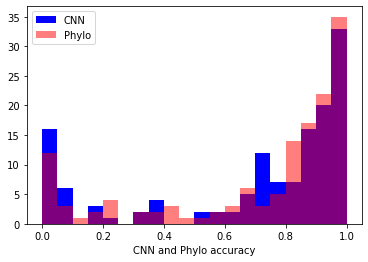

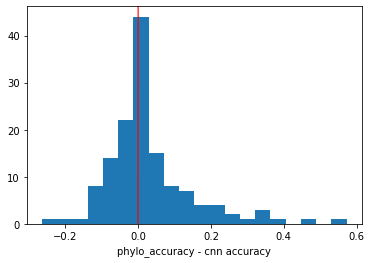

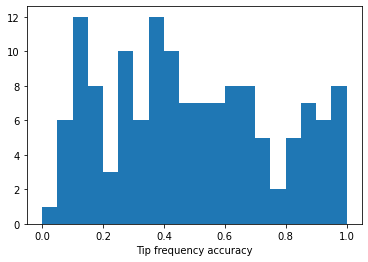

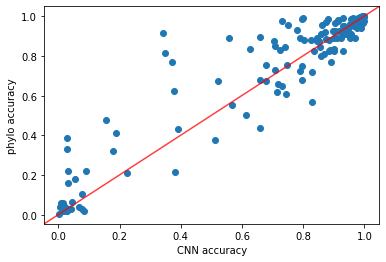

105


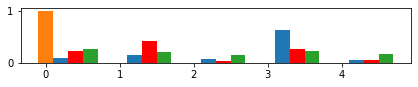

56


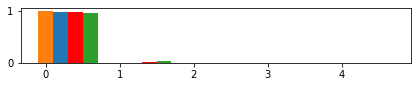

39


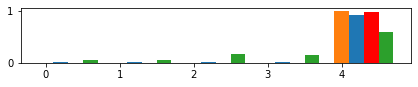

111


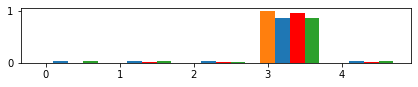

95


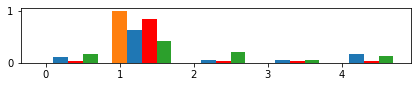

61


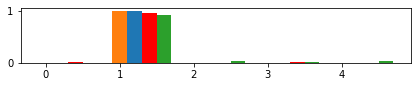

113


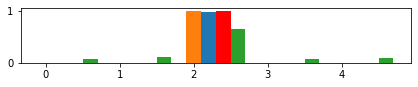

119


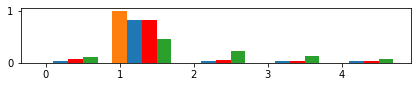

120


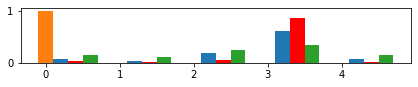

40


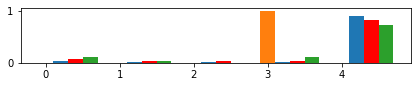

In [8]:
# make summary plots of root location predictions
accuracy_tipfreq, tip_loc_distro = cn.tip_freq_accuracy(extant_treeLocation_tensor, extant_labels, num_locs = 5)

cnn_root_accuracy, cnn_root_auc, cnn_root_crossentropy = cn.summarize_categorical_performance(extant_labels[:,:5],
                                                                                            extant_root_loc_preds)
phylo_root_accuracy, phylo_root_auc, phylo_root_crossentropy = cn.summarize_categorical_performance(extant_labels[:,:5],
                                                                                            extant_post_root_freq)

print("CNN auc cross-ent and mean acc: ", cnn_root_auc, cnn_root_crossentropy, np.mean(cnn_root_accuracy) )
print("Phy auc cross-ent and mean acc: ", phylo_root_auc, phylo_root_crossentropy, np.mean(phylo_root_accuracy))
cn.root_summary_plots(cnn_root_accuracy, phylo_root_accuracy, accuracy_tipfreq)
cn.plot_root_pred_examples(extant_labels[:,0:5], extant_root_loc_preds, extant_post_root_freq, tip_loc_distro, 
                           num_plots = 10, num_locs = 5)


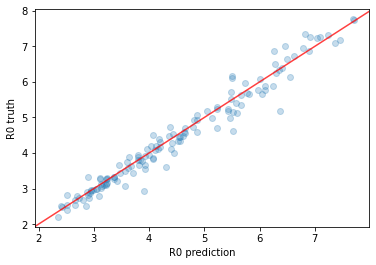

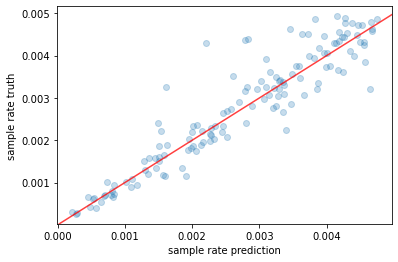

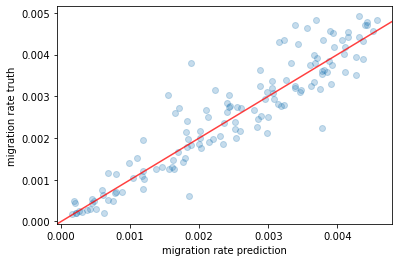

(138, 3)

In [9]:
cn.plot_preds_labels(cnn_extant_preds, extant_labels[:,5:8])
cnn_extant_preds.shape

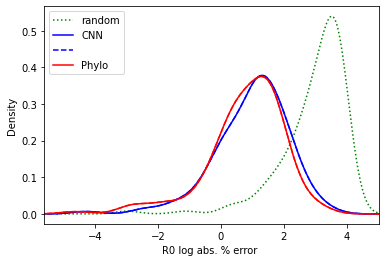

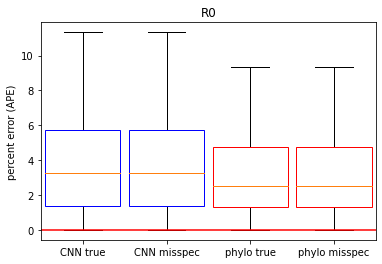

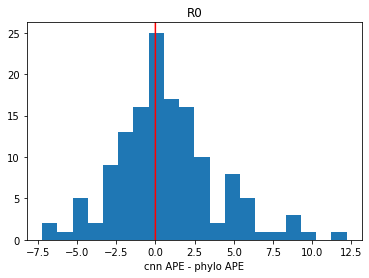

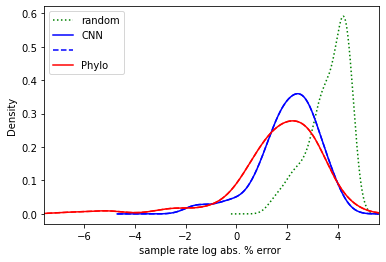

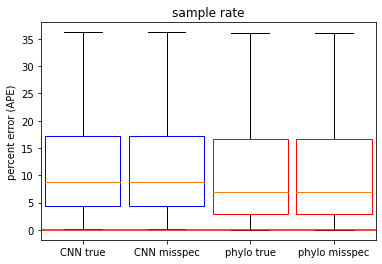

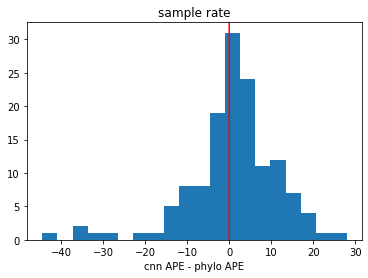

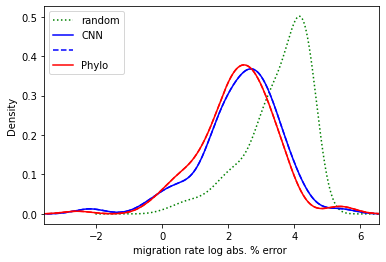

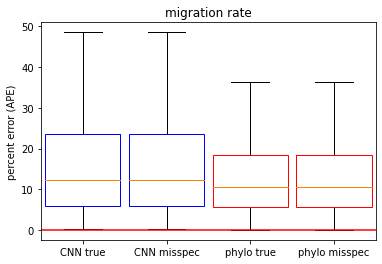

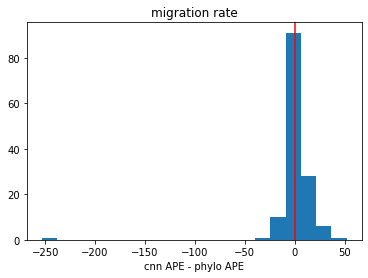

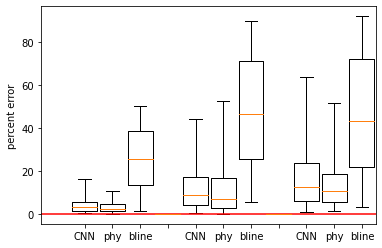

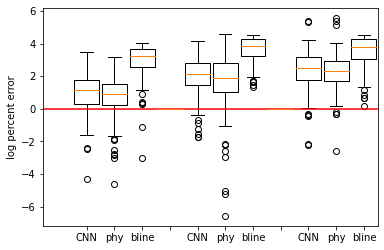

In [10]:
# make summary plots regression predictions
cnn_extant_ape = 100 * np.abs((cnn_extant_preds - phylo_labels)/phylo_labels)
mean_bl_R0 = 2 + (8 - 2)/2
mean_bl_delta = 0.0001 + (0.005 - 0.0001)/2
mean_bl_migration = 0.0001 + (0.005 - 0.0001)/2
mean_bl_R0_ape = 100 * np.abs(phylo_labels[:, 0] - mean_bl_R0)/mean_bl_R0
mean_bl_sample_ape = 100 * np.abs(phylo_labels[:, 1] - mean_bl_delta)/mean_bl_delta
mean_bl_migration_ape = 100 * np.abs(phylo_labels[:, 2] - mean_bl_migration)/mean_bl_migration
baseline_ape = np.column_stack((mean_bl_R0_ape, mean_bl_sample_ape, mean_bl_migration_ape))


cn.make_experiment_density_plots(cnn_extant_ape, extant_post_ape,
                       cnn_extant_ape, extant_post_ape, baseline_ape,
                          plot_legend = ["random", "CNN", "", "Phylo", ])

# make log-scale box plots
all_error_for_plotting = [cnn_extant_ape[:,0],extant_post_ape[:,0],baseline_ape[:,0], 0,
            cnn_extant_ape[:,1],extant_post_ape[:,1],baseline_ape[:,1], 0,
            cnn_extant_ape[:,2],extant_post_ape[:,2],baseline_ape[:,2]]

plt.boxplot(all_error_for_plotting,
           widths=0.9,
            labels = ["CNN", "phy", "bline", "",
                     "CNN", "phy", "bline", "",
                     "CNN", "phy", "bline"], 
            whis = (2.5, 97.5), showfliers = False)

plt.axline((0,0),slope=0,color="red")
plt.ylabel("percent error")
plt.show()


plt.boxplot([np.log(cnn_extant_ape[:,0]), np.log(extant_post_ape[:,0]), np.log(baseline_ape[:,0]), 0,
            np.log(cnn_extant_ape[:,1]), np.log(extant_post_ape[:,1]), np.log(baseline_ape[:,1]), 0,
            np.log(cnn_extant_ape[:,2]), np.log(extant_post_ape[:,2]), np.log(baseline_ape[:,2])],
           widths=0.9,
            labels = ["CNN", "phy", "bline", "",
                     "CNN", "phy", "bline", "",
                     "CNN", "phy", "bline"])

plt.axline((0,0),slope=0,color="red")
plt.ylabel("log percent error")
    
plt.show()


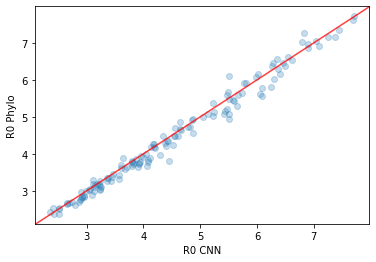

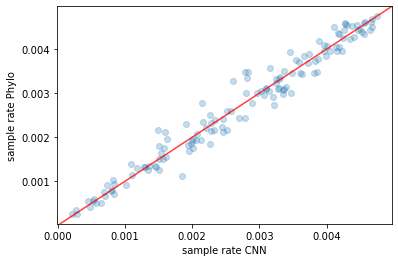

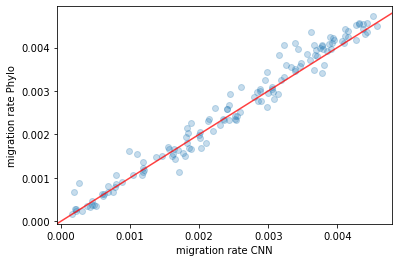

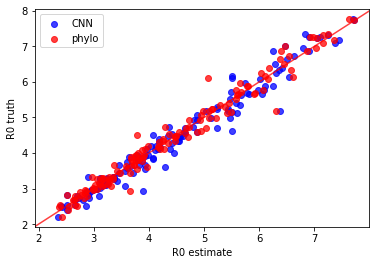

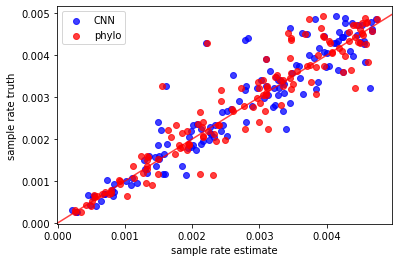

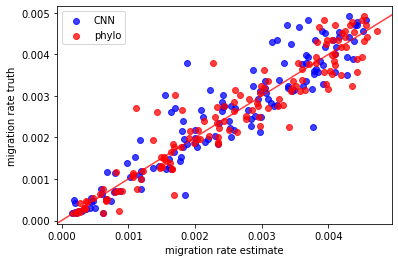

Ttest_indResult(statistic=1.3716429752920927, pvalue=0.17129672525780879)
Ttest_indResult(statistic=2.0717916595279378, pvalue=0.03922047127158002)
Ttest_indResult(statistic=0.6110276171755478, pvalue=0.5416878514351406)
KstestResult(statistic=0.10869565217391304, pvalue=0.3898890388244114)
KstestResult(statistic=0.13768115942028986, pvalue=0.1463241040404268)
KstestResult(statistic=0.10869565217391304, pvalue=0.3898890388244114)


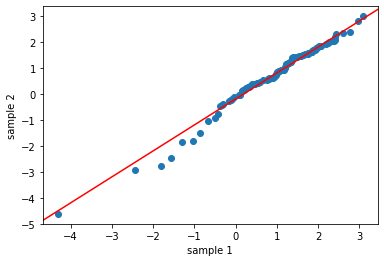

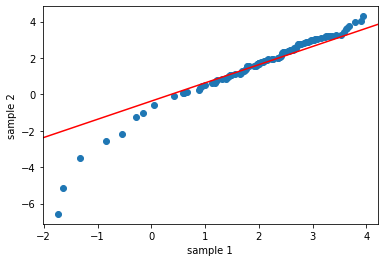

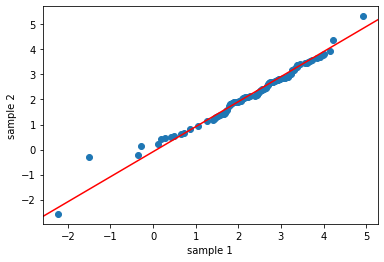

[None, None, None]

In [11]:
cn.plot_preds_labels(cnn_extant_preds, extant_post,
                         param_names = ["R0", "sample rate", "migration rate"],
                         axis_labels = ["CNN", "Phylo"])

cn.plot_overlaid_scatter(cnn_extant_preds, extant_post,
                         phylo_labels, 
                         param_names = ["R0", "sample rate", "migration rate"])

[print(sp.ttest_ind(np.log(cnn_extant_ape[:,i]), np.log(extant_post_ape[:,i]))) for i in range(0,3)]
[print(sp.kstest(np.log(cnn_extant_ape[:,i]), np.log(extant_post_ape[:,i]))) for i in range(0,3)]
[cn.qq_plot(np.log(cnn_extant_ape[:,i]), np.log(extant_post_ape[:,i]), num_quantiles = 100) for i in range(0,3)]

In [12]:
# print percent absolute error medians

# look into wasserstein distances from baseline: scipy.stats.wasserstein_distance()

print("R0")
print("mean difference in APE (CNN_APE - Phylo_APE): ",  np.mean(cnn_extant_ape[:,0] - extant_post_ape[:,0]))
print(np.median(extant_post_ape[:,0]), np.quantile(extant_post_ape[:,0], [0.025, 0.975]))
print(np.median(cnn_extant_ape[:,0]), np.quantile(cnn_extant_ape[:,0], [0.025, 0.975]))
print(np.median(baseline_ape[:,0]), np.quantile(baseline_ape[:,0], [0.025, 0.975]))
# bins = np.arange(1,10, step = 0.5)[0]
# print("  KL ratio: ", (sp.entropy(np.histogram(cnn_extant_ape[:,0], bins=bins),  np.histogram(mean_bl_R0_ape, bins=bins))/ 
#                        sp.entropy(np.histogram(extant_post_ape[:,0], np.histogram(mean_bl_R0_ape)))
print("delta")
print("mean difference in APE (CNN_APE - Phylo_APE): ",  np.mean(cnn_extant_ape[:,1] - extant_post_ape[:,1]))
print(np.median(extant_post_ape[:,1]), np.quantile(extant_post_ape[:,1], [0.025, 0.975]))
print(np.median(cnn_extant_ape[:,1]), np.quantile(cnn_extant_ape[:,1], [0.025, 0.975]))
print(np.median(baseline_ape[:,1]), np.quantile(baseline_ape[:,1], [0.025, 0.975]))
# print("  KL ratio: ", (sp.entropy(np.histogram(cnn_extant_ape[:,1], bins=bins), np.histogram(mean_bl_sample_ape, bins=bins) ) / 
#                        sp.entropy(np.histogram(extant_post_ape[:,1], bins=bins), np.histogram(mean_bl_sample_ape, bins=bins))))
print("migration")
print("mean difference in APE (CNN_APE - Phylo_APE): ",  np.mean(cnn_extant_ape[:,2] - extant_post_ape[:,2]))
print(np.median(extant_post_ape[:,2]), np.quantile(extant_post_ape[:,2], [0.025, 0.975]))
print(np.median(cnn_extant_ape[:,2]), np.quantile(cnn_extant_ape[:,2], [0.025, 0.975]))
print(np.median(baseline_ape[:,2]), np.quantile(baseline_ape[:,2], [0.025, 0.975]))
# print("  KL ratio: ", (sp.entropy(np.histogram(cnn_extant_ape[:,2], bins=bins), np.histogram(mean_bl_migration_ape, bins=bins)) / 
#                        sp.entropy(np.histogram(extant_post_ape[:,2], bins=bins), np.histogram(mean_bl_migration_ape, bins=bins))))

# cn.plot_preds_labels(extant_post, phylo_labels)
# cn.plot_preds_labels(cnn_extant_preds, phylo_labels)


R0
mean difference in APE (CNN_APE - Phylo_APE):  0.7723949062208294
2.513034520733662 [ 0.0705267  13.67663775]
3.2525063649981103 [ 0.20294934 18.05195831]
25.815599999999996 [ 1.47246 51.33372]
delta
mean difference in APE (CNN_APE - Phylo_APE):  0.7447774724412064
6.865305227354107 [ 0.06148563 54.44316786]
8.723899477126006 [ 0.3429632 46.7645445]
46.666666666666664 [ 5.49019608 90.25490196]
migration
mean difference in APE (CNN_APE - Phylo_APE):  0.8289747078079776
10.52220033661575 [ 0.97212904 55.70302777]
12.373400406024587 [ 0.70914861 66.17436736]
43.333333333333336 [ 2.68627451 92.38235294]


In [13]:
im.reload(cn)

<module 'cnn_utilities' from 'C:\\Users\\ammon_work\\Desktop\\git_repos\\epi_geo_simulation\\neural_network_dev\\cnn_utilities.py'>

In [14]:
#########################################
# misspecified sample rate ##
#########################################
misspec_delta_data = pd.read_csv("data_files/extant_misspec_delta.cblv.csv", 
                   header =None, error_bad_lines = False, index_col = 0).to_numpy()
# load labels data
misspec_delta_labels = pd.read_csv("data_files/extant_misspec_delta_labels.csv",
                    header = None, error_bad_lines = False).to_numpy()

# phylo mean prediction file
miss_phylo_post_mean = pd.read_table("data_files/extant_misspec_delta_rates.postmeans", 
                                    index_col=0, header = None).to_numpy()

misspec_delta_phylo_root = pd.read_table("data_files/extant_misspec_delta_root_probs.tsv", 
                                   header = None, index_col = 0).to_numpy()



In [15]:

#########################
# prepare input tensors #
#########################


# normalize with training means and sds
misspec_delta_subsample_prop = misspec_delta_data[:,(max_tips-1) * 7]
misspec_delta_mu = misspec_delta_data[:,(max_tips-3) * 7]
misspec_delta_num_tips = cn.get_num_tips(misspec_delta_data)
misspec_delta_tmrca = misspec_delta_labels[:,8]
misspec_delta_mean_bl = misspec_delta_labels[:,9]

aux_misspec_delta = np.vstack((misspec_delta_mu, misspec_delta_subsample_prop, misspec_delta_num_tips,
                              misspec_delta_tmrca, misspec_delta_mean_bl)).transpose()
norm_aux_misspec_delta = cn.normalize(aux_misspec_delta, (train_aux_priors_means, train_aux_priors_sd))

misspec_delta_treeLocation_tensor, misspec_delta_prior_tensor = cn.create_data_tensors(misspec_delta_data,
                                                                          mu = norm_aux_misspec_delta[:,0],
                                                                          subsample_prop = norm_aux_misspec_delta[:,1],
                                                                            num_tips = norm_aux_misspec_delta[:,2],
                                                                            tmrca = norm_aux_misspec_delta[:,3],
                                                                            mean_bl = norm_aux_misspec_delta[:,4],
                                                                            num_locs = num_locs,
                                                                            max_tips = max_tips,
                                                                            cblv_contains_mu_rho = True)

In [16]:
# predict
misspec_delta_normalized_preds = my_model.predict([misspec_delta_treeLocation_tensor, 
                                         misspec_delta_prior_tensor])

# denormalize preds use label means and sd from training data normalization
misspec_delta_denormalized_preds = cn.denormalize(misspec_delta_normalized_preds, train_means[0:3], train_sd[0:3])
misspec_delta_denormalized_preds = np.exp(misspec_delta_denormalized_preds)

# measure error
miss_abserror = np.abs(np.subtract(misspec_delta_denormalized_preds, misspec_delta_labels[:,5:8]))
miss_mape = np.multiply(100, np.abs(np.divide(miss_abserror, misspec_delta_labels[:,5:8])))

# PREDICT root location
misspec_delta_root_loc_preds = my_root_model.predict([misspec_delta_treeLocation_tensor, misspec_delta_prior_tensor])


In [17]:
train_means

array([ 1.43429760e+00, -6.14377761e+00, -6.22762769e+00,  2.56199474e-02,
        9.03419350e-01,  2.18847799e+02,  1.00000009e+02,  1.71042149e+01])

In [18]:
############################
# save predictions to file #
############################
# CNN predictions
df_misspec_delta_cnn_output = pd.DataFrame(np.concatenate((misspec_delta_denormalized_preds, misspec_delta_root_loc_preds), axis = 1), 
                                           columns = ["R0", "sample_rate", "migration_rate",
                                                      "Loc1", "Loc2", "Loc3", "Loc4", "Loc5"])
df_misspec_delta_cnn_output.to_csv('output/misspec_delta_cnn_preds.tsv', sep = "\t", index = False)

# Phylogeographical predictions
df_misspec_delta_true_output = pd.DataFrame(np.concatenate((miss_phylo_post_mean, misspec_delta_phylo_root), axis = 1),
                                        columns = ["R0", "sample_rate", "migration_rate",
                                                      "Loc1", "Loc2", "Loc3", "Loc4", "Loc5"])
df_misspec_delta_true_output.to_csv('output/misspec_delta_phylo_means.tsv', sep = '\t', index = False)

# true values
df_misspec_delta_phylo_output = pd.DataFrame(np.concatenate((misspec_delta_labels[:,5:8], misspec_delta_labels[:,:5]), axis = 1),
                                        columns = ["R0", "sample_rate", "migration_rate",
                                                      "Loc1", "Loc2", "Loc3", "Loc4", "Loc5"])
df_misspec_delta_phylo_output.to_csv('output/misspec_delta_labels.tsv', sep = '\t', index = False)


CNN auc cross-ent and median acc:  0.9213400805896867 0.8092233160790845 0.8177760541439056
Phy auc cross-ent and median acc:  0.9447400910428738 0.6865365493636426 0.885


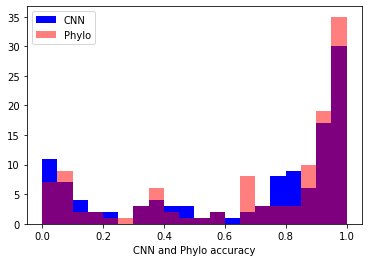

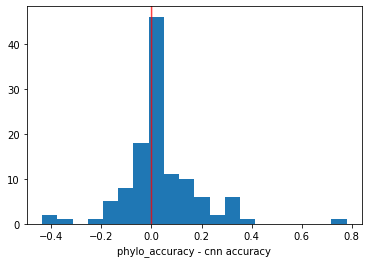

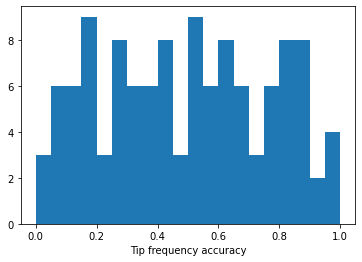

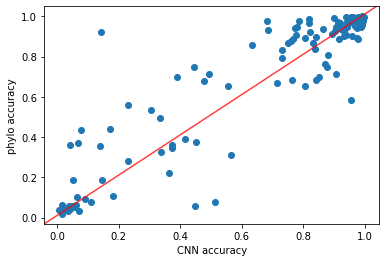

49


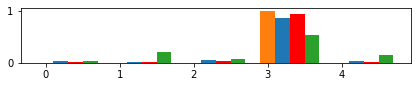

46


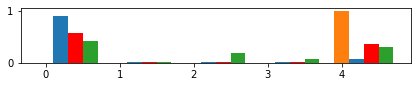

1


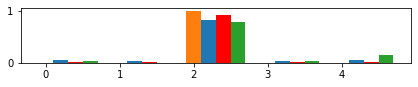

15


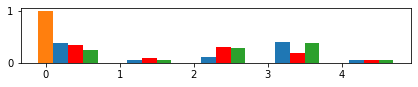

76


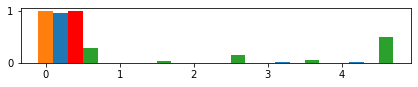

104


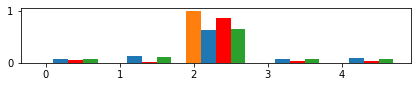

20


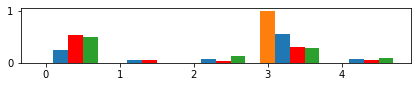

21


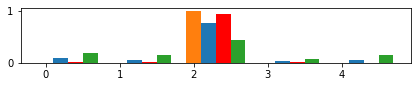

62


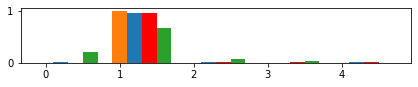

22


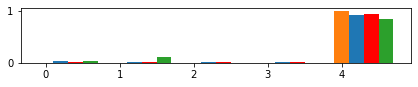

In [19]:
# make summary plots of root location predictions
# NOTE: see cnn_utilities.py for cat cross-entropy tolerance setting (for 0 and 1)
# summarize results
misspec_delta_accuracy_tipfreq, misspec_delta_tip_loc_distro = cn.tip_freq_accuracy(misspec_delta_treeLocation_tensor, 
                                                        misspec_delta_labels, num_locs = 5)
misspec_delta_cnn_root_accuracy, misspec_delta_cnn_root_auc, misspec_delta_cnn_root_crossentropy = cn.summarize_categorical_performance(misspec_delta_labels[:,:5],
                                                                                            misspec_delta_root_loc_preds)
misspec_delta_phylo_root_accuracy, misspec_delta_phylo_root_auc, misspec_delta_phylo_root_crossentropy = cn.summarize_categorical_performance(misspec_delta_labels[:,:5],
                                                                                            misspec_delta_phylo_root)

print("CNN auc cross-ent and median acc: ", 
      misspec_delta_cnn_root_auc, 
      misspec_delta_cnn_root_crossentropy, 
      np.median(misspec_delta_cnn_root_accuracy) )
print("Phy auc cross-ent and median acc: ", 
      misspec_delta_phylo_root_auc, 
      misspec_delta_phylo_root_crossentropy, 
      np.median(misspec_delta_phylo_root_accuracy))

# plotting
cn.root_summary_plots(misspec_delta_cnn_root_accuracy, 
                      misspec_delta_phylo_root_accuracy, 
                      misspec_delta_accuracy_tipfreq)
cn.plot_root_pred_examples(misspec_delta_labels[:,0:5], 
                           misspec_delta_root_loc_preds, 
                           misspec_delta_phylo_root, 
                           misspec_delta_tip_loc_distro, 
                           num_plots = 10, num_locs = 5)


In [20]:
################################
# misspecified migration rate ##
################################
misspec_migration_data = pd.read_csv("data_files/extant_misspec_m.cblv.csv", 
                   header =None, error_bad_lines = False, index_col=0).to_numpy()
# load labels data
misspec_migration_labels = pd.read_csv("data_files/extant_misspec_m_labels.csv",
                    header = None, error_bad_lines = False, index_col = None).to_numpy()

# phylo prediction files
miss_migration_phylo_post_mean = pd.read_table("data_files/extant_misspec_m_rates.postmeans",
                                              index_col=0, header = None).to_numpy()
misspec_migration_phylo_root = pd.read_table("data_files/extant_misspec_m_root_probs.tsv", 
                                   header = None, index_col = 0).to_numpy()


In [21]:
#########################
# prepare input tensors #
#########################

# normalize with training means and sds
misspec_migration_subsample_prop = misspec_migration_data[:,(max_tips-1) * 7]
misspec_migration_mu = misspec_migration_data[:,(max_tips-3) * 7]
misspec_migration_num_tips = cn.get_num_tips(misspec_migration_data)
misspec_migration_tmrca = misspec_migration_labels[:,8]
misspec_migration_mean_bl = misspec_migration_labels[:,9]

aux_misspec_migration = np.vstack((misspec_migration_mu, misspec_migration_subsample_prop, misspec_migration_num_tips,
                              misspec_migration_tmrca, misspec_migration_mean_bl)).transpose()
norm_aux_misspec_migration = cn.normalize(aux_misspec_migration, (train_aux_priors_means, train_aux_priors_sd))

misspec_migration_treeLocation_tensor, misspec_migration_prior_tensor = cn.create_data_tensors(misspec_migration_data,
                                                                          mu = norm_aux_misspec_migration[:,0],
                                                                          subsample_prop = norm_aux_misspec_migration[:,1],
                                                                            num_tips = norm_aux_misspec_migration[:,2],
                                                                            tmrca = norm_aux_misspec_migration[:,3],
                                                                            mean_bl = norm_aux_misspec_migration[:,4],
                                                                            num_locs = num_locs,
                                                                            max_tips = max_tips,
                                                                            cblv_contains_mu_rho = True)


In [22]:
# predict phylodynamics
miss_migration_normalized_preds = my_model.predict([misspec_migration_treeLocation_tensor, 
                                         misspec_migration_prior_tensor])

# denormalize preds use label means and sd from training data normalization
miss_migration_denormalized_preds = cn.denormalize(miss_migration_normalized_preds, train_means[0:3], train_sd[0:3])
miss_migration_denormalized_preds = np.exp(miss_migration_denormalized_preds)

# measure error
miss_migration_abserror = np.abs(np.subtract(miss_migration_denormalized_preds, misspec_migration_labels[:,5:8]))
miss_migration_mape = np.multiply(100, np.abs(np.divide(miss_migration_abserror, misspec_migration_labels[:,5:8])))

# predict root location
miss_migration_root_preds = my_root_model.predict([misspec_migration_treeLocation_tensor, 
                                                          misspec_migration_prior_tensor])


In [23]:
############################
# save predictions to file #
############################
# CNN predictions
df_misspec_migration_cnn_output = pd.DataFrame(np.concatenate((miss_migration_denormalized_preds, miss_migration_root_preds), axis = 1), 
                                           columns = ["R0", "sample_rate", "migration_rate",
                                                      "Loc1", "Loc2", "Loc3", "Loc4", "Loc5"])
df_misspec_migration_cnn_output.to_csv('output/misspec_migration_cnn_preds.tsv', sep = "\t", index = False)

# Phylogeographical predictions
df_misspec_migration_true_output = pd.DataFrame(np.concatenate((miss_migration_phylo_post_mean, misspec_migration_phylo_root), axis = 1),
                                        columns = ["R0", "sample_rate", "migration_rate",
                                                      "Loc1", "Loc2", "Loc3", "Loc4", "Loc5"])
df_misspec_migration_true_output.to_csv('output/misspec_migration_phylo_means.tsv', sep = '\t', index = False)

# true values
df_misspec_migration_phylo_output = pd.DataFrame(np.concatenate((misspec_migration_labels[:,5:8], misspec_migration_labels[:,:5]), axis = 1),
                                        columns = ["R0", "sample_rate", "migration_rate",
                                                      "Loc1", "Loc2", "Loc3", "Loc4", "Loc5"])
df_misspec_migration_phylo_output.to_csv('output/misspec_migration_labels.tsv', sep = '\t', index = False)


CNN auc cross-ent and median acc:  0.9409192050912705 0.707075004463291 0.8661057651042938
Phy auc cross-ent and median acc:  0.9444384329396442 0.6680685049873407 0.885


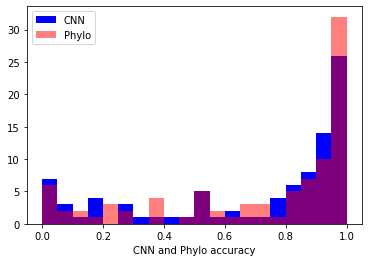

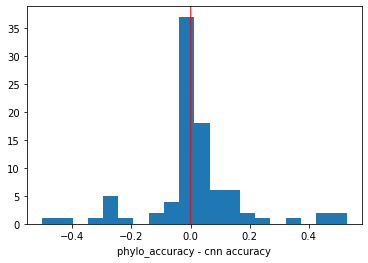

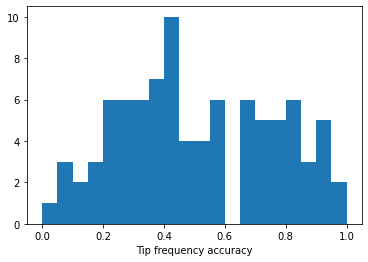

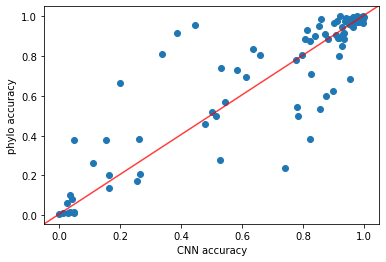

60


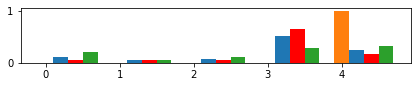

44


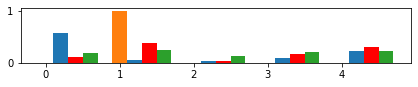

23


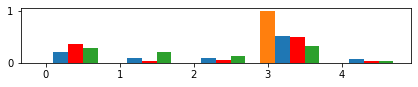

71


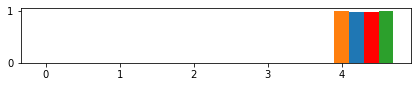

18


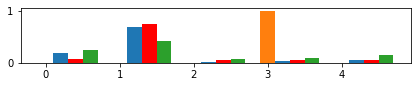

13


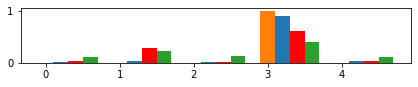

74


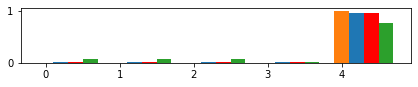

26


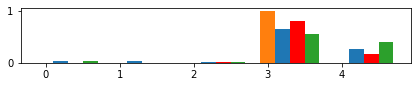

7


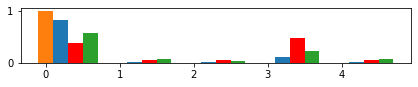

51


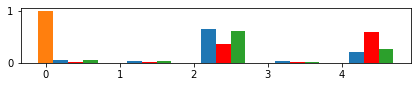

In [24]:
# make summary plots of root location predictions
# NOTE: see cnn_utilities.py for cat cross-entropy tolerance setting (for 0 and 1)
# summarize results
misspec_migration_accuracy_tipfreq, misspec_migration_tip_loc_distro = cn.tip_freq_accuracy(misspec_migration_treeLocation_tensor, 
                                                        misspec_migration_labels[:,0:5], num_locs = 5)
misspec_migration_cnn_root_accuracy, misspec_migration_cnn_root_auc, misspec_migration_cnn_root_crossentropy = cn.summarize_categorical_performance(misspec_migration_labels[:,:5],
                                                                                            miss_migration_root_preds)
misspec_migration_phylo_root_accuracy, misspec_migration_phylo_root_auc, misspec_migration_phylo_root_crossentropy = cn.summarize_categorical_performance(misspec_migration_labels[:,:5],
                                                                                            misspec_migration_phylo_root)

print("CNN auc cross-ent and median acc: ", 
      misspec_migration_cnn_root_auc, 
      misspec_migration_cnn_root_crossentropy, 
      np.median(misspec_migration_cnn_root_accuracy) )
print("Phy auc cross-ent and median acc: ", 
      misspec_migration_phylo_root_auc, 
      misspec_migration_phylo_root_crossentropy, 
      np.median(misspec_migration_phylo_root_accuracy))

# plotting
cn.root_summary_plots(misspec_migration_cnn_root_accuracy, 
                      misspec_migration_phylo_root_accuracy, 
                      misspec_migration_accuracy_tipfreq)
cn.plot_root_pred_examples(misspec_migration_labels[:,0:5], 
                           miss_migration_root_preds, 
                           misspec_migration_phylo_root, 
                           misspec_migration_tip_loc_distro, 
                           num_plots = 10, num_locs = 5)


In [25]:
#######################
## misspecified tree ##
#######################
# read cblv data
misspec_tree_cblv = pd.read_csv("data_files/extant_misspec_tree.cblv.csv",
                    header = None, error_bad_lines = False, index_col = 0).to_numpy()

misspec_tree_param_labels = pd.read_csv("data_files/extant_misspec_tree_labels.csv",
                                       header = None, error_bad_lines = False).to_numpy()

# read phylo data
misspec_tree_phylo = pd.read_table("data_files/extant_misspec_tree_rates.postmeans",
                    header = None, error_bad_lines = False, index_col = 0).to_numpy()

misspec_tree_phylo_root = pd.read_table("data_files/extant_misspec_tree_root_probs.tsv",
                    header = None, error_bad_lines = False, index_col = 0).to_numpy()


# tree distances data
tree_overlap = pd.read_table("data_files/extant_misspec_tree_proportion_branches_shared.tsv",
                            header = None, index_col = 0).to_numpy()



In [26]:
#########################
# prepare input tensors #
#########################

# normalize with training means and sds
misspectree_subsample_prop = misspec_tree_cblv[:,(max_tips-1) * 7]
misspectree_mu = misspec_tree_cblv[:,(max_tips-3) * 7]
misspectree_num_tips = cn.get_num_tips(misspec_tree_cblv)
misspectree_tmrca = misspec_tree_param_labels[:,8]
misspectree_mean_bl = misspec_tree_param_labels[:,9]

aux_misspectree = np.vstack((misspectree_mu, misspectree_subsample_prop, misspectree_num_tips,
                              misspectree_tmrca, misspectree_mean_bl)).transpose()
norm_aux_misspectree = cn.normalize(aux_misspectree, (train_aux_priors_means, train_aux_priors_sd))

misspectree_treeLocation_tensor, misspectree_prior_tensor = cn.create_data_tensors(misspec_tree_cblv,
                                                                          mu = norm_aux_misspectree[:,0],
                                                                          subsample_prop = norm_aux_misspectree[:,1],
                                                                            num_tips = norm_aux_misspectree[:,2],
                                                                            tmrca = norm_aux_misspectree[:,3],
                                                                            mean_bl = norm_aux_misspectree[:,4],
                                                                            num_locs = num_locs,
                                                                            max_tips = max_tips,
                                                                            cblv_contains_mu_rho = True)








In [27]:
# predict
normed_misspec_tree_preds = my_model.predict([misspectree_treeLocation_tensor, 
                                              misspectree_prior_tensor])

# denormalize predictions
misspec_tree_preds = cn.denormalize(normed_misspec_tree_preds, train_means[0:3], train_sd[0:3])
misspec_tree_preds = np.exp(misspec_tree_preds)

# predict root location
misspec_tree_root_preds = my_root_model.predict([misspectree_treeLocation_tensor, 
                                                          misspectree_prior_tensor])


In [28]:
############################
# save predictions to file #
############################

# Error trees
# CNN predictions
df_misspec_tree_cnn_output = pd.DataFrame(np.concatenate((misspec_tree_preds, misspec_tree_root_preds), axis = 1), 
                                           columns = ["R0", "sample_rate", "migration_rate",
                                                      "Loc1", "Loc2", "Loc3", "Loc4", "Loc5"])
df_misspec_tree_cnn_output.to_csv('output/misspec_tree_cnn_preds.tsv', sep = "\t", index = False)

# Phylogeographical predictions
df_misspec_tree_true_output = pd.DataFrame(np.concatenate((misspec_tree_phylo, misspec_tree_phylo_root), axis = 1),
                                        columns = ["R0", "sample_rate", "migration_rate",
                                                      "Loc1", "Loc2", "Loc3", "Loc4", "Loc5"])
df_misspec_tree_true_output.to_csv('output/misspec_tree_phylo_means.tsv', sep = '\t', index = False)

# true values
df_misspec_tree_phylo_output = pd.DataFrame(np.concatenate((misspec_tree_param_labels[:,5:8], misspec_tree_param_labels[:,:5]), axis = 1),
                                        columns = ["R0", "sample_rate", "migration_rate",
                                                      "Loc1", "Loc2", "Loc3", "Loc4", "Loc5"])
df_misspec_tree_phylo_output.to_csv('output/misspec_tree_labels.tsv', sep = '\t', index = False)



In [29]:
##################################
# misspecified number locations ##
##################################
misspec_numloc_data = pd.read_csv("data_files/extant_misspec_numloc.cblv.csv", 
                   header =None, error_bad_lines = False, index_col=0).to_numpy()
# load labels data
misspec_numloc_labels = pd.read_csv("data_files/extant_misspec_numloc_labels.csv",
                    header = None, error_bad_lines = False, index_col = None).to_numpy()

# phylo prediction files
miss_numloc_phylo_post_mean = pd.read_table("data_files/extant_misspec_numloc_rates.postmeans",
                                               index_col=0, header = None).to_numpy()
misspec_numloc_phylo_root = pd.read_table("data_files/extant_misspec_numloc_root_probs.tsv", 
                                   header = None, index_col = 0).to_numpy()

In [30]:
# prepare input tensors #

# normalize with training means and sds
misspec_numloc_subsample_prop = misspec_numloc_data[:,(max_tips-1) * 7]
misspec_numloc_mu = misspec_numloc_data[:,(max_tips-3) * 7]
misspec_numloc_num_tips = cn.get_num_tips(misspec_numloc_data)
misspec_numloc_tmrca = misspec_numloc_labels[:,8]
misspec_numloc_mean_bl = misspec_numloc_labels[:,9]

aux_misspec_numloc = np.vstack((misspec_numloc_mu, misspec_numloc_subsample_prop, misspec_numloc_num_tips,
                              misspec_numloc_tmrca, misspec_numloc_mean_bl)).transpose()
norm_aux_misspec_numloc = cn.normalize(aux_misspec_numloc, (train_aux_priors_means, train_aux_priors_sd))

misspec_numloc_treeLocation_tensor, misspec_numloc_prior_tensor = cn.create_data_tensors(misspec_numloc_data,
                                                                          mu = norm_aux_misspec_numloc[:,0],
                                                                          subsample_prop = norm_aux_misspec_numloc[:,1],
                                                                            num_tips = norm_aux_misspec_numloc[:,2],
                                                                            tmrca = norm_aux_misspec_numloc[:,3],
                                                                            mean_bl = norm_aux_misspec_numloc[:,4],
                                                                            num_locs = num_locs,
                                                                            max_tips = max_tips,
                                                                            cblv_contains_mu_rho = True)

In [31]:
# predict phylodynamics
miss_numloc_normalized_preds = my_model.predict([misspec_numloc_treeLocation_tensor, 
                                         misspec_numloc_prior_tensor])

# denormalize preds use label means and sd from training data normalization
miss_numloc_denormalized_preds = cn.denormalize(miss_numloc_normalized_preds, train_means[0:3], train_sd[0:3])
miss_numloc_denormalized_preds = np.exp(miss_numloc_denormalized_preds)

# measure error
miss_numloc_abserror = np.abs(np.subtract(miss_numloc_denormalized_preds, misspec_numloc_labels[:,5:8]))
miss_numloc_mape = np.multiply(100, np.abs(np.divide(miss_numloc_abserror, misspec_numloc_labels[:,5:8])))
miss_numloc_phylo_abserror = np.abs(np.subtract(miss_numloc_phylo_post_mean , misspec_numloc_labels[:,5:8] ))
miss_numloc_phylo_mape = np.multiply(100, np.abs(np.divide(miss_numloc_phylo_abserror, misspec_numloc_labels[:,5:8])))


# predict root location
miss_numloc_root_preds = my_root_model.predict([misspec_numloc_treeLocation_tensor, 
                                                          misspec_numloc_prior_tensor])

In [32]:
############################
# save predictions to file #
############################
# CNN predictions
df_misspec_migration_cnn_output = pd.DataFrame(np.concatenate((miss_numloc_denormalized_preds, miss_numloc_root_preds), axis = 1), 
                                           columns = ["R0", "sample_rate", "migration_rate",
                                                      "Loc1", "Loc2", "Loc3", "Loc4", "Loc5"])
df_misspec_migration_cnn_output.to_csv('output/misspec_numloc_cnn_preds.tsv', sep = "\t", index = False)

# Phylogeographical predictions
df_misspec_migration_true_output = pd.DataFrame(np.concatenate((miss_numloc_phylo_post_mean, misspec_numloc_phylo_root), axis = 1),
                                        columns = ["R0", "sample_rate", "migration_rate",
                                                      "Loc1", "Loc2", "Loc3", "Loc4", "Loc5"])
df_misspec_migration_true_output.to_csv('output/misspec_numloc_phylo_means.tsv', sep = '\t', index = False)

# true values
df_misspec_migration_phylo_output = pd.DataFrame(np.concatenate((misspec_numloc_labels[:,5:8], misspec_numloc_labels[:,:5]), axis = 1),
                                        columns = ["R0", "sample_rate", "migration_rate",
                                                      "Loc1", "Loc2", "Loc3", "Loc4", "Loc5"])
df_misspec_migration_phylo_output.to_csv('output/misspec_numloc_labels.tsv', sep = '\t', index = False)


In [33]:
####################
# misspecified R0 ##
####################
misspec_R0_data = pd.read_csv("data_files/extant_misspec_R0.cblv.csv", 
                   header =None, error_bad_lines = False, index_col = 0).to_numpy()
# load labels data
misspec_R0_labels = pd.read_csv("data_files/extant_misspec_R0_labels.csv",
                    header = None, error_bad_lines = False).to_numpy()

# phylo prediction files
miss_R0_phylo_post_mean = pd.read_table("data_files/extant_misspec_R0_rates.postmeans",
                                              index_col=0, header = None).to_numpy()
misspec_R0_phylo_root = pd.read_table("data_files/extant_misspec_R0_root_probs.tsv", 
                                   header = None, index_col = 0).to_numpy()

In [34]:
misspec_R0_phylo_root.shape

(93, 5)

In [35]:
#########################
# prepare input tensors #
#########################

# normalize with training means and sds
misspec_R0_subsample_prop = misspec_R0_data[:,(max_tips-1) * 7]
misspec_R0_mu = misspec_R0_data[:,(max_tips-3) * 7]
misspec_R0_num_tips = cn.get_num_tips(misspec_R0_data)
misspec_R0_tmrca = misspec_R0_labels[:,8]
misspec_R0_mean_bl = misspec_R0_labels[:,9]

aux_misspec_R0 = np.vstack((misspec_R0_mu, misspec_R0_subsample_prop, misspec_R0_num_tips,
                              misspec_R0_tmrca, misspec_R0_mean_bl)).transpose()
norm_aux_misspec_R0 = cn.normalize(aux_misspec_R0, (train_aux_priors_means, train_aux_priors_sd))

misspec_R0_treeLocation_tensor, misspec_R0_prior_tensor = cn.create_data_tensors(misspec_R0_data,
                                                                          mu = norm_aux_misspec_R0[:,0],
                                                                          subsample_prop = norm_aux_misspec_R0[:,1],
                                                                            num_tips = norm_aux_misspec_R0[:,2],
                                                                            tmrca = norm_aux_misspec_R0[:,3],
                                                                            mean_bl = norm_aux_misspec_R0[:,4],
                                                                            num_locs = num_locs,
                                                                            max_tips = max_tips,
                                                                            cblv_contains_mu_rho = True)

In [36]:
# predict phylodynamics
miss_R0_normalized_preds = my_model.predict([misspec_R0_treeLocation_tensor, 
                                         misspec_R0_prior_tensor])

# denormalize preds use label means and sd from training data normalization
miss_R0_denormalized_preds = cn.denormalize(miss_R0_normalized_preds, train_means[0:3], train_sd[0:3])
miss_R0_denormalized_preds = np.exp(miss_R0_denormalized_preds)

# measure error
miss_R0_abserror = np.abs(np.subtract(miss_R0_denormalized_preds, misspec_R0_labels[:,5:8]))
miss_R0_mape = np.multiply(100, np.abs(np.divide(miss_R0_abserror, misspec_R0_labels[:,5:8])))

# predict root location
miss_R0_root_preds = my_root_model.predict([misspec_R0_treeLocation_tensor, 
                                                          misspec_R0_prior_tensor])

In [37]:
############################
# save predictions to file #
############################
# CNN predictions
df_misspec_R0_cnn_output = pd.DataFrame(np.concatenate((miss_R0_denormalized_preds, miss_R0_root_preds), axis = 1), 
                                           columns = ["R0", "sample_rate", "migration_rate",
                                                      "Loc1", "Loc2", "Loc3", "Loc4", "Loc5"])
df_misspec_R0_cnn_output.to_csv('output/misspec_R0_cnn_preds.tsv', sep = "\t", index = False)

# # Phylogeographical predictions
df_misspec_R0_true_output = pd.DataFrame(np.concatenate((miss_R0_phylo_post_mean, misspec_R0_phylo_root), axis = 1),
                                        columns = ["R0", "sample_rate", "migration_rate",
                                                      "Loc1", "Loc2", "Loc3", "Loc4", "Loc5"])
df_misspec_R0_true_output.to_csv('output/misspec_R0_phylo_means.tsv', sep = '\t', index = False)

# true values
df_misspec_R0_phylo_output = pd.DataFrame(np.concatenate((misspec_R0_labels[:,5:8], misspec_R0_labels[:,:5]), axis = 1),
                                        columns = ["R0", "sample_rate", "migration_rate",
                                                      "Loc1", "Loc2", "Loc3", "Loc4", "Loc5"])
df_misspec_R0_phylo_output.to_csv('output/misspec_R0_labels.tsv', sep = '\t', index = False)

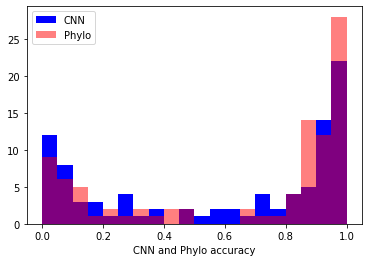

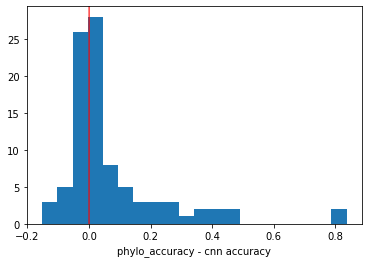

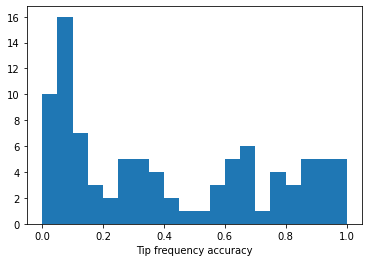

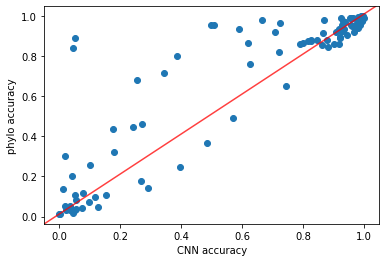

24


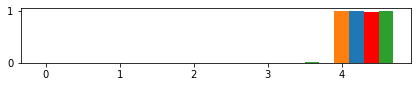

1


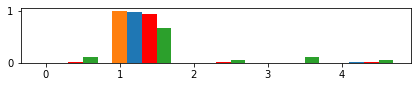

49


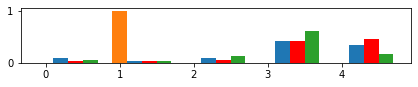

27


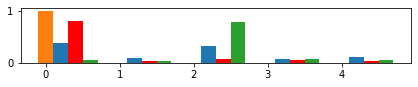

47


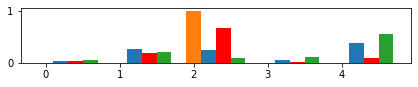

65


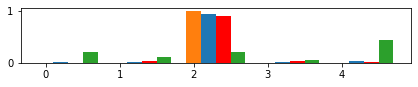

80


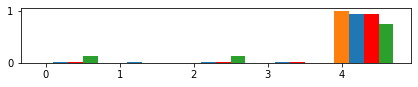

35


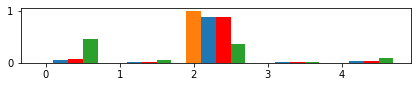

83


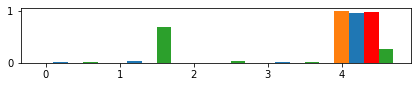

10


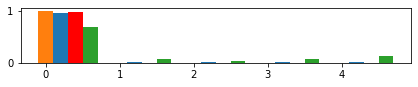

In [38]:
# make summary plots of root location predictions
# NOTE: see cnn_utilities.py for cat cross-entropy tolerance setting (for 0 and 1)
# summarize results
misspec_R0_accuracy_tipfreq, misspec_R0_tip_loc_distro = cn.tip_freq_accuracy(misspec_R0_treeLocation_tensor, 
                                                        misspec_R0_labels[:,0:5], num_locs = 5)
misspec_R0_cnn_root_accuracy, misspec_R0_cnn_root_auc, misspec_R0_cnn_root_crossentropy = cn.summarize_categorical_performance(misspec_R0_labels[:,:5],
                                                                                            miss_R0_root_preds)
misspec_R0_phylo_root_accuracy, misspec_R0_phylo_root_auc, misspec_R0_phylo_root_crossentropy = cn.summarize_categorical_performance(misspec_R0_labels[:,:5],
                                                                                            misspec_R0_phylo_root)

# plotting
cn.root_summary_plots(misspec_R0_cnn_root_accuracy, 
                      misspec_R0_phylo_root_accuracy, 
                      misspec_R0_accuracy_tipfreq)
cn.plot_root_pred_examples(misspec_R0_labels[:,0:5], 
                           miss_R0_root_preds, 
                           misspec_R0_phylo_root, 
                           misspec_R0_tip_loc_distro, 
                           num_plots = 10, num_locs = 5)

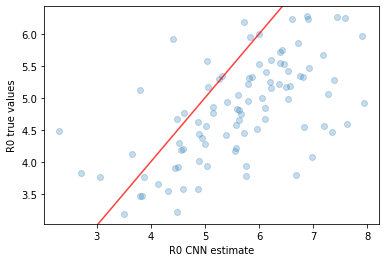

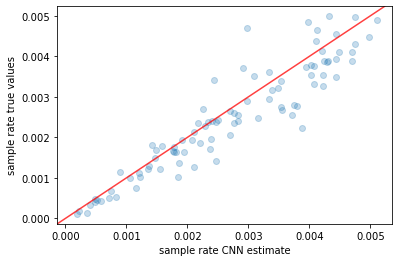

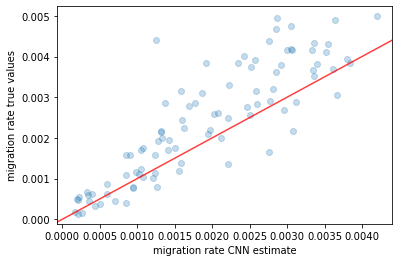

In [39]:
cn.plot_preds_labels((miss_R0_denormalized_preds[:,0:3]), 
                     (misspec_R0_labels[:,5:8]), 
                     param_names = ["R0", "sample rate", "migration rate"], 
                     axis_labels = ['CNN estimate', 'true values'])

In [40]:
# my hacky way of getting precise estimates of run time for cnn predictions for single trees
shape1 = 1
shape2 = extant_treeLocation_tensor.shape[1]
shape3 = extant_treeLocation_tensor.shape[2]

predict_times = []
for i in range(0,extant_treeLocation_tensor.shape[0]):
    f = io.StringIO()
    with redirect_stdout(f):
        my_model.predict([np.repeat(extant_treeLocation_tensor[i,:,:].reshape((shape1,shape2,shape3)), 100, axis =0),
                          np.repeat(extant_prior_tensor[i,:,:].reshape(1,5,2), 100, axis = 0)], verbose = 1)
    out = f.getvalue()
    
    reout = re.search("[0-9]+[um]s", out).group()
    reout = reout.replace('ms','000')
    reout = reout.replace('us','')
    predict_times.append(float(reout)/100)
    

df_predict_times = pd.DataFrame(predict_times, columns = None)
df_predict_times.to_csv('output/extant_phylocomp_cnn_pred_times.tsv', sep = "\t", index = False)

In [41]:
my_model


{'name': 'conv1d_59', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': (3,), 'strides': (1,), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1,), 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
(3, 7, 64)
0


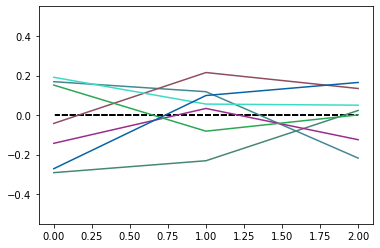

1


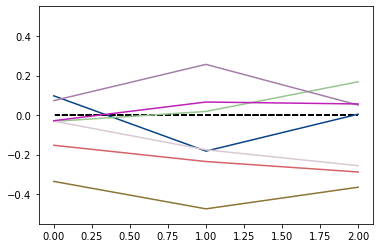

2


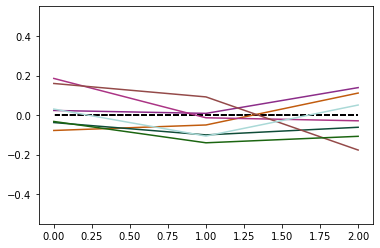

3


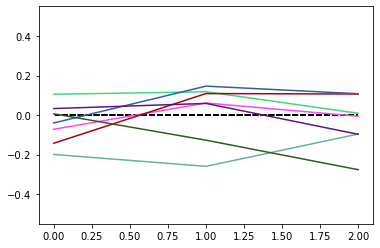

4


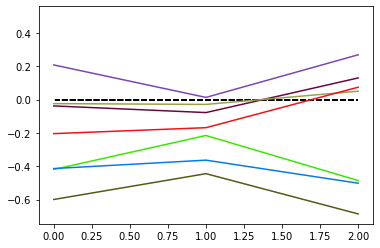

5


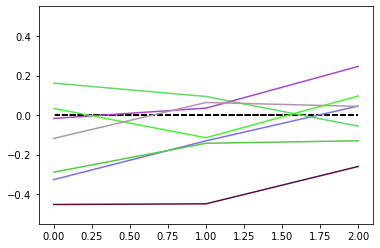

6


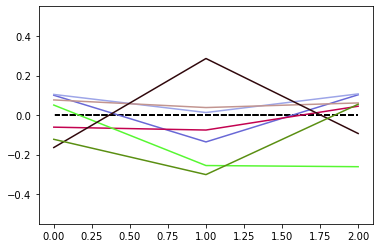

7


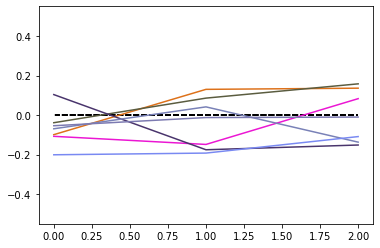

8


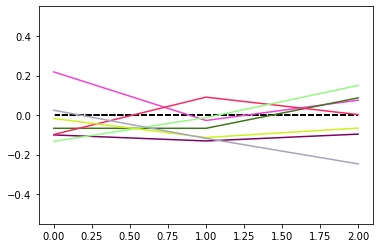

9


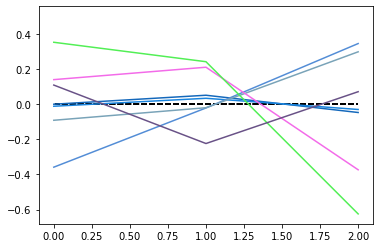

10


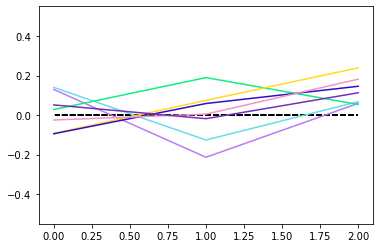

11


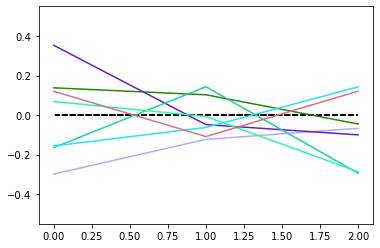

12


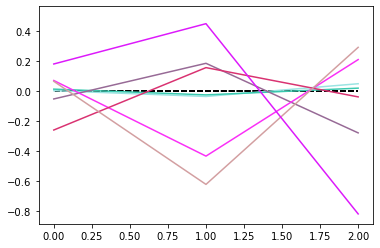

13


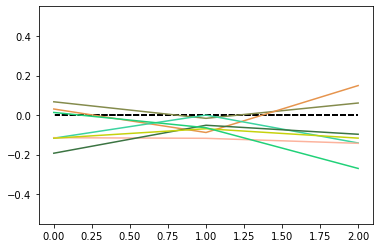

14


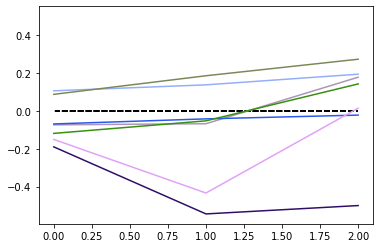

15


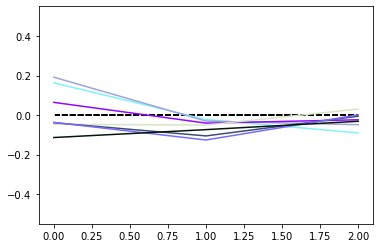

16


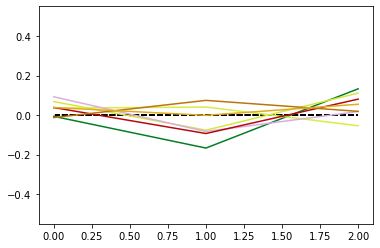

17


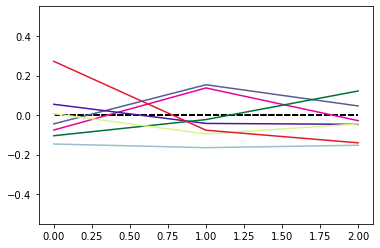

18


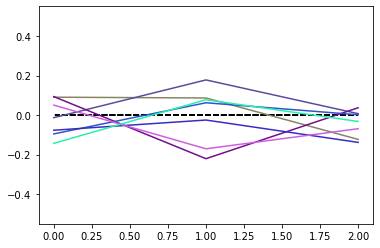

19


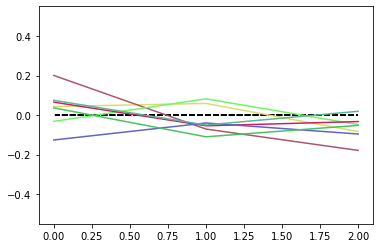

20


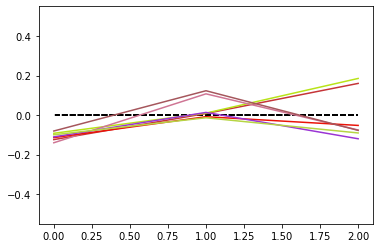

21


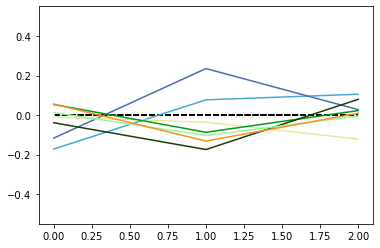

22


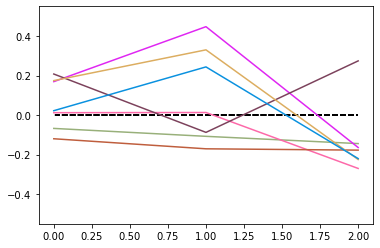

23


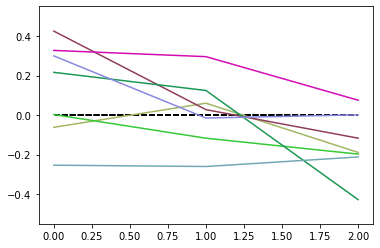

24


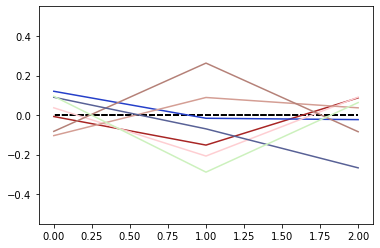

25


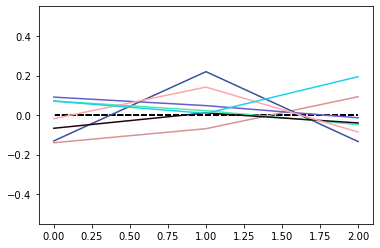

26


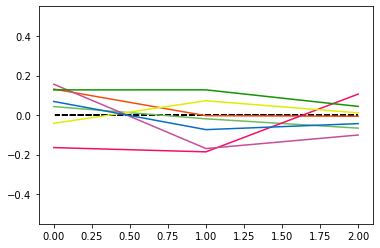

27


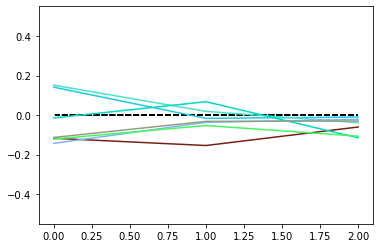

28


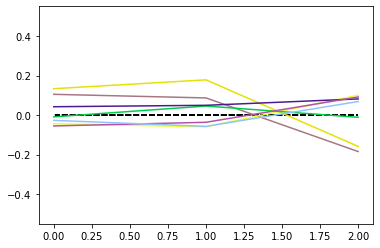

29


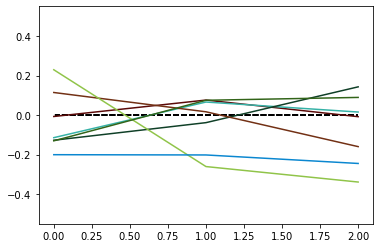

30


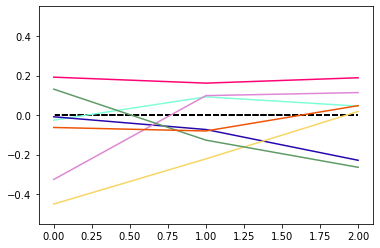

31


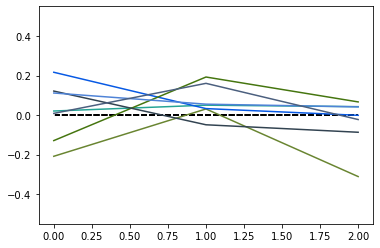

32


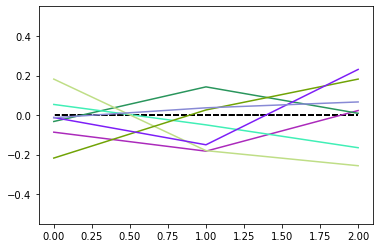

33


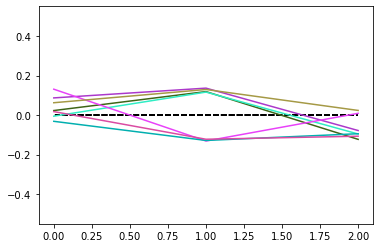

34


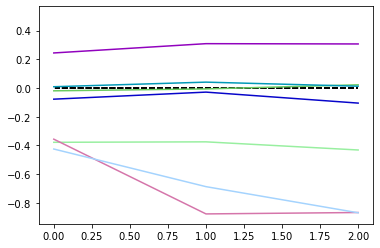

35


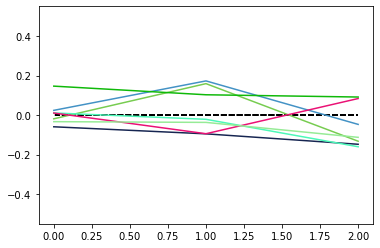

36


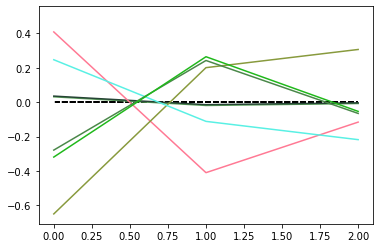

37


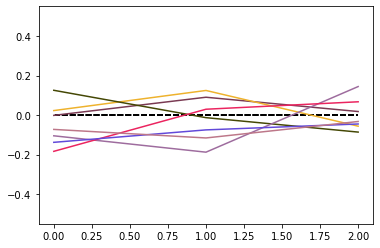

38


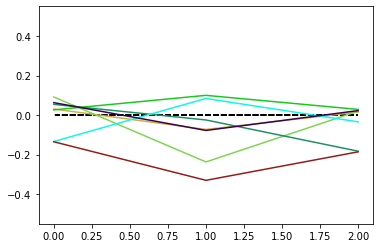

39


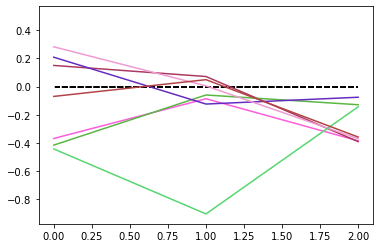

40


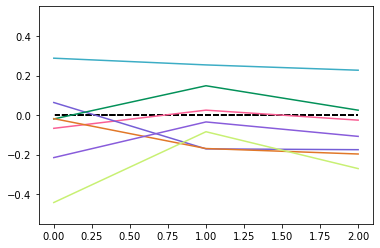

41


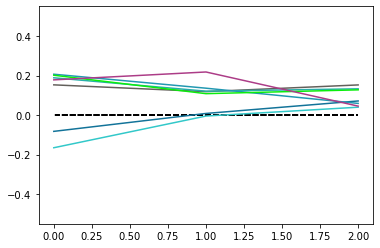

42


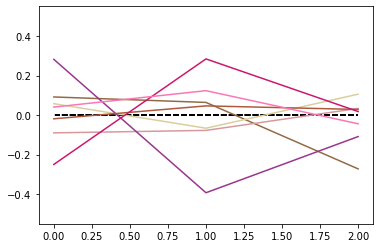

43


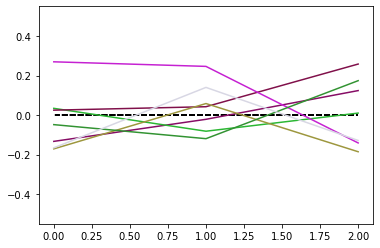

44


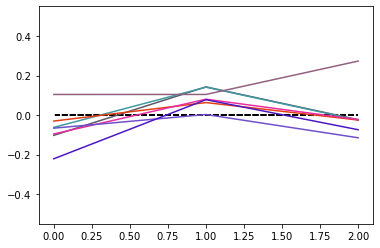

45


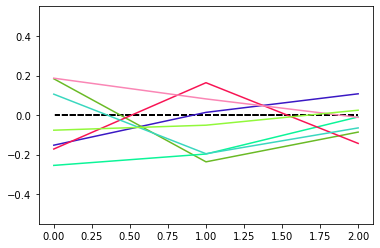

46


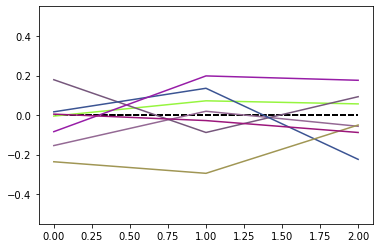

47


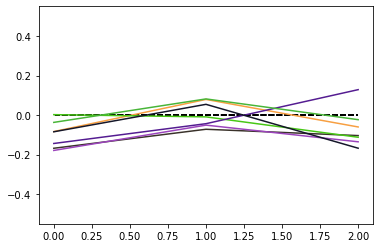

48


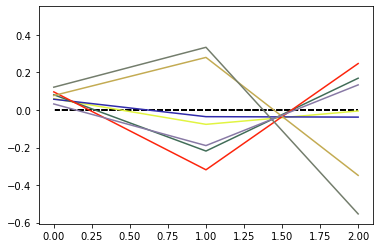

49


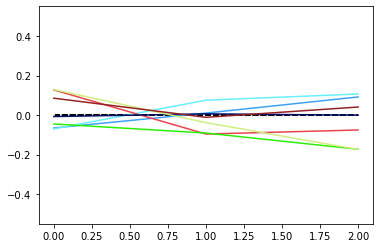

50


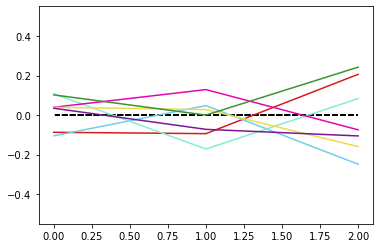

51


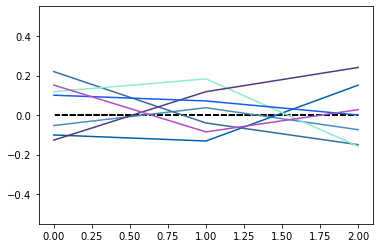

52


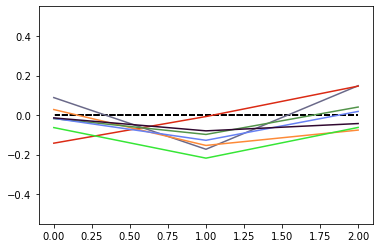

53


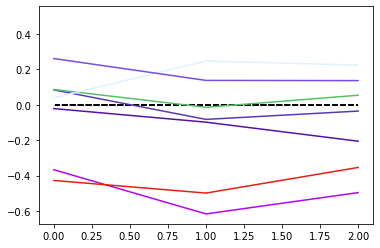

54


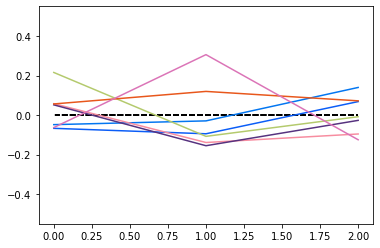

55


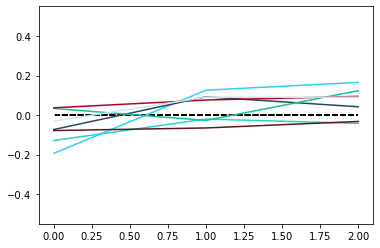

56


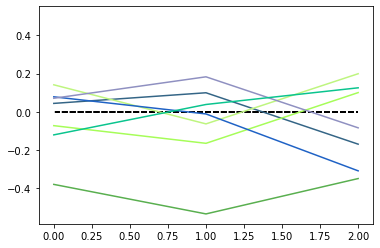

57


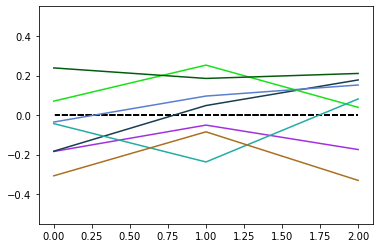

58


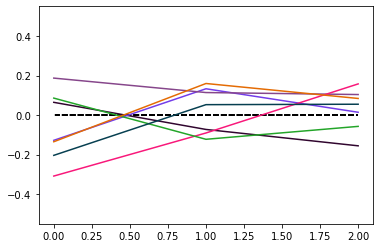

59


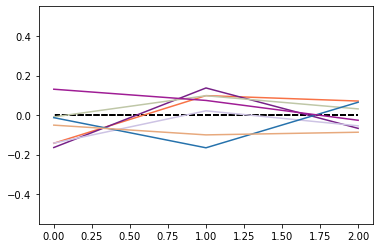

60


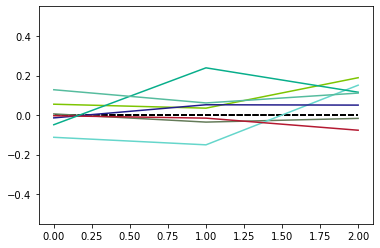

61


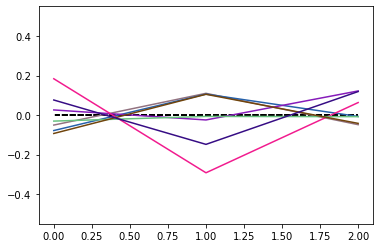

62


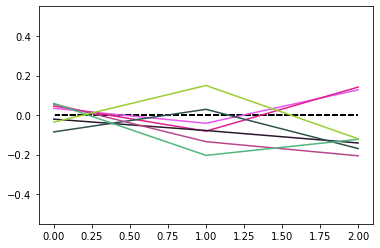

63


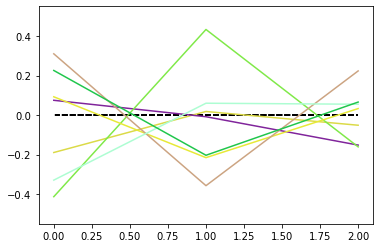

{'name': 'dense_25', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_in', 'distribution': 'normal', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
(128, 64)
0


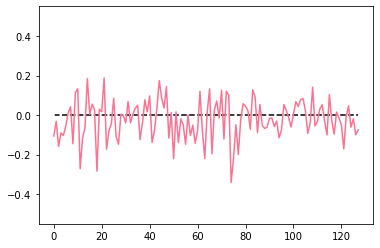

1


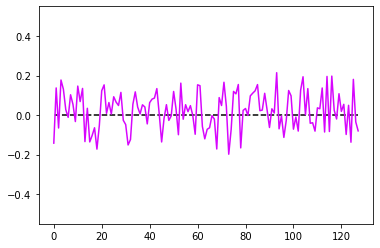

2


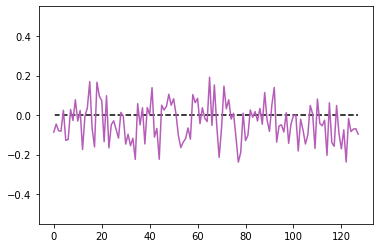

3


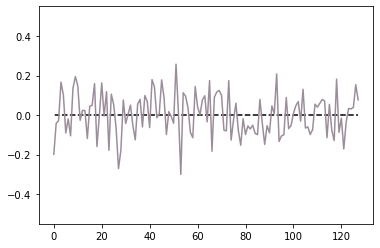

4


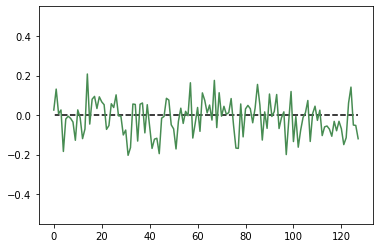

5


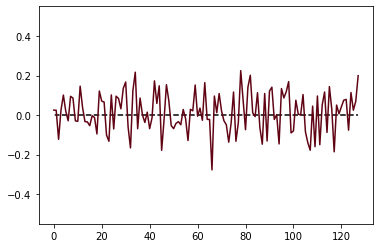

6


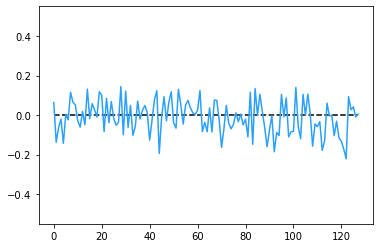

7


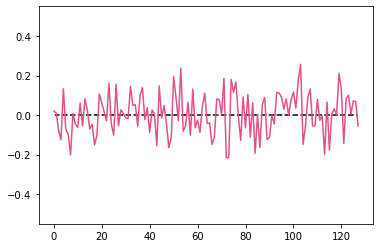

8


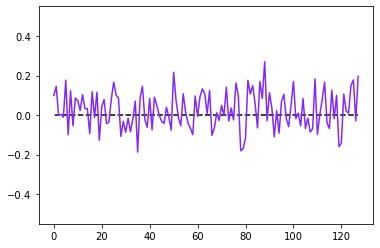

9


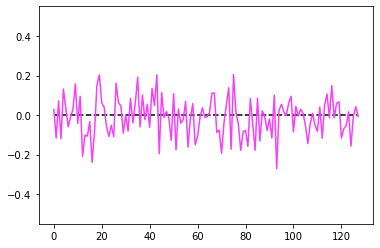

10


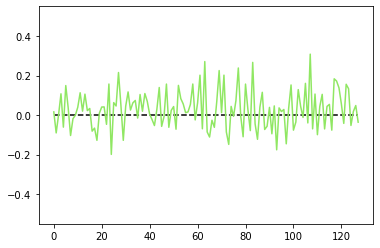

11


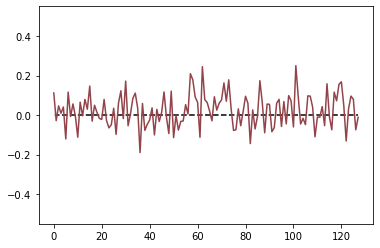

12


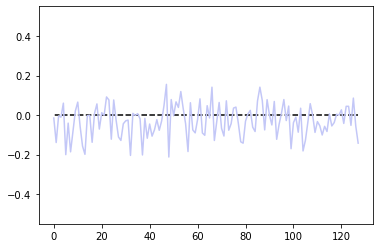

13


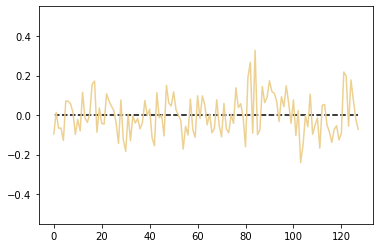

14


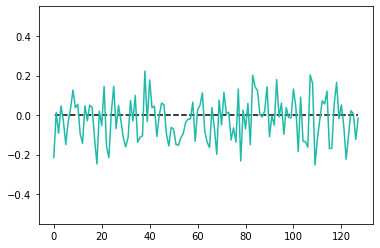

15


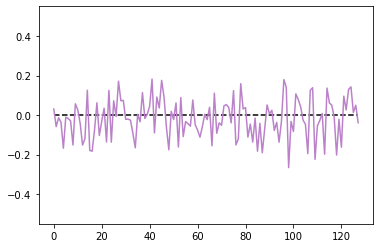

16


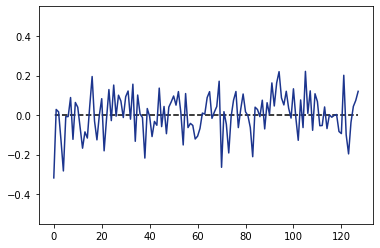

17


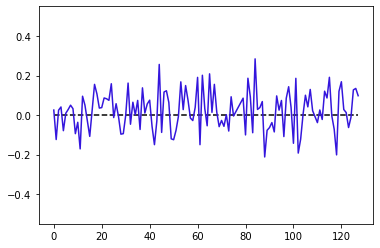

18


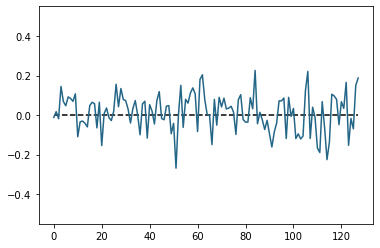

19


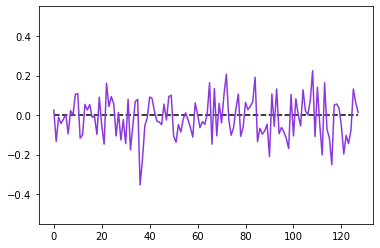

20


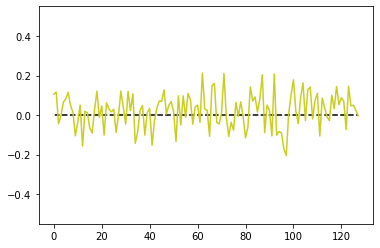

21


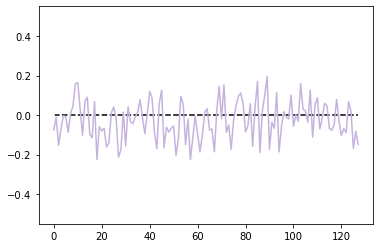

22


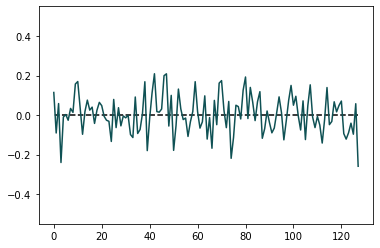

23


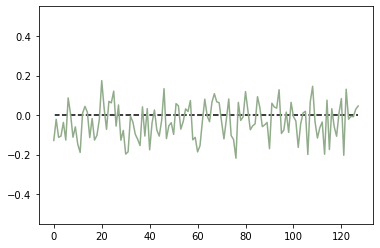

24


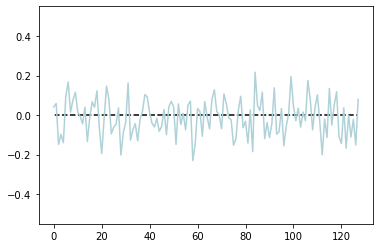

25


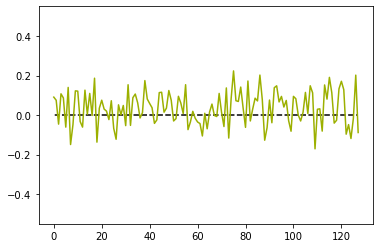

26


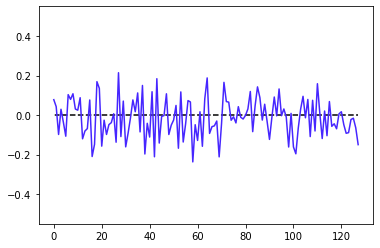

27


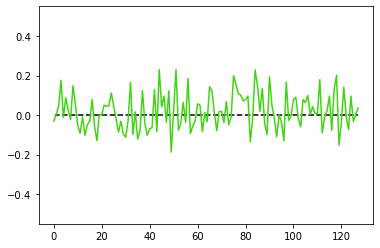

28


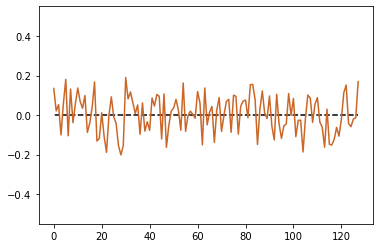

29


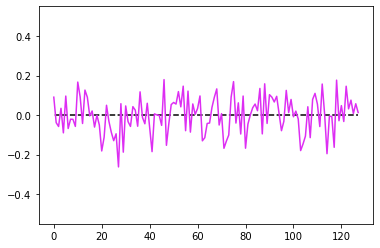

30


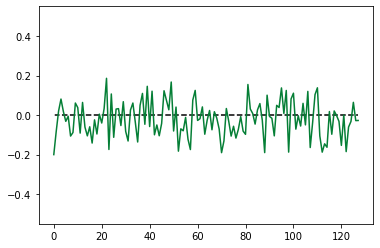

31


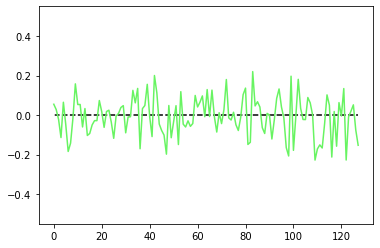

32


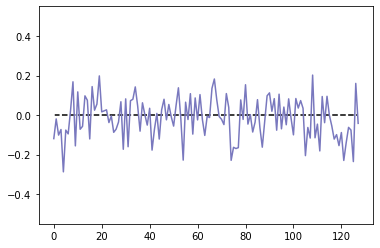

33


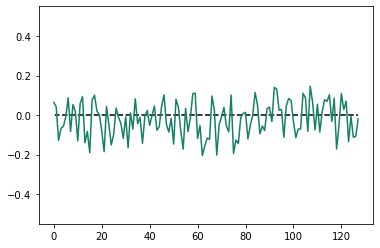

34


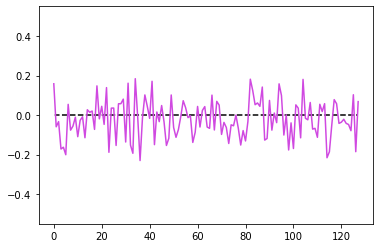

35


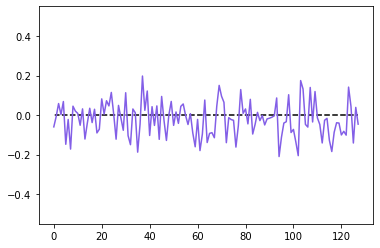

36


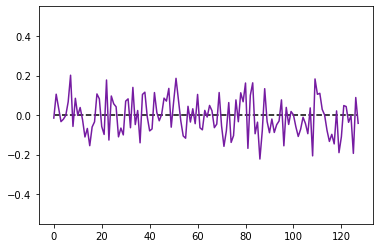

37


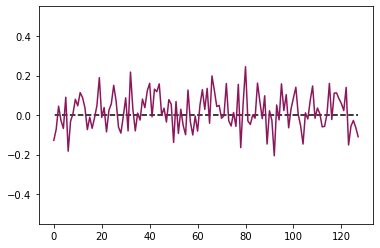

38


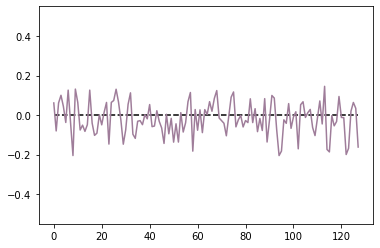

39


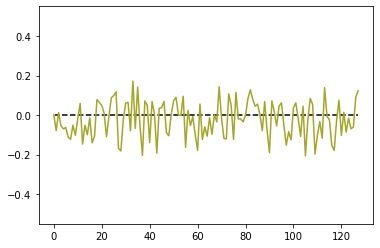

40


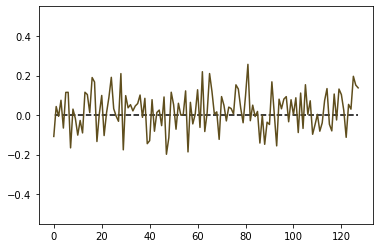

41


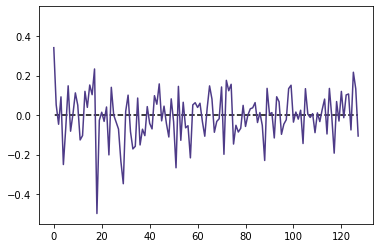

42


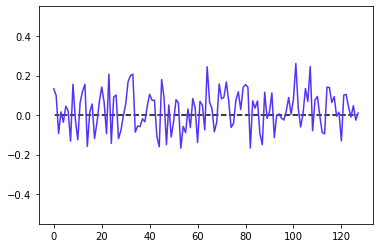

43


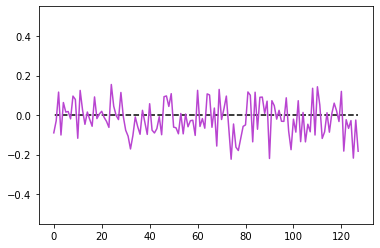

44


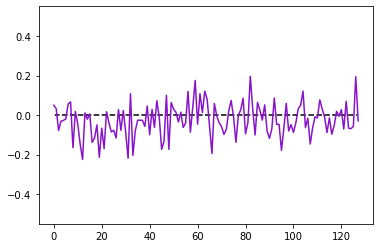

45


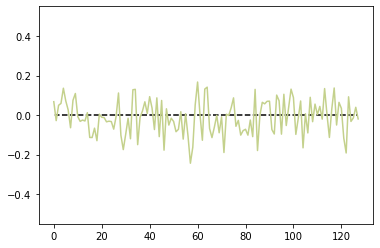

46


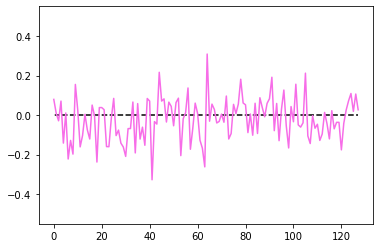

47


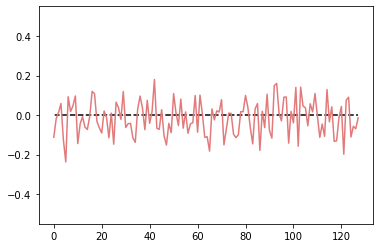

48


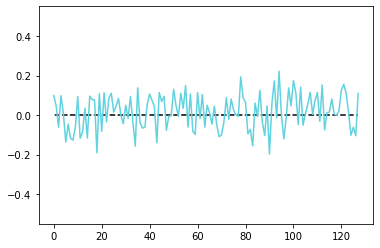

49


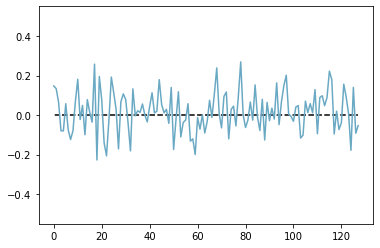

50


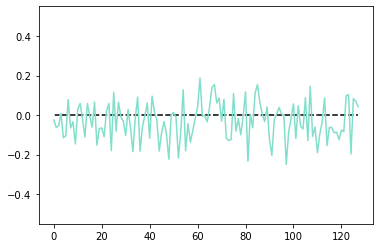

51


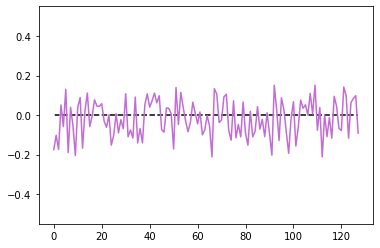

52


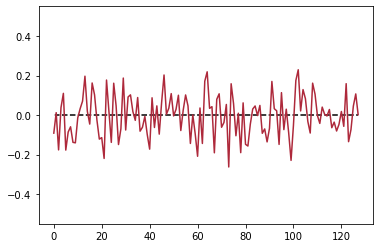

53


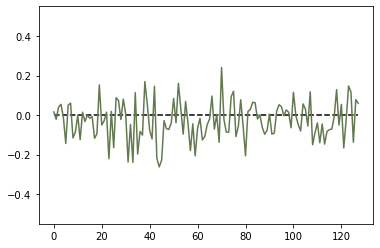

54


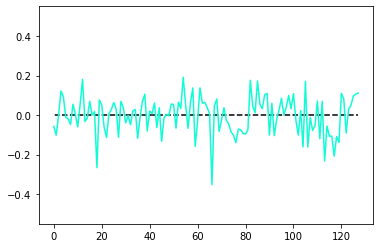

55


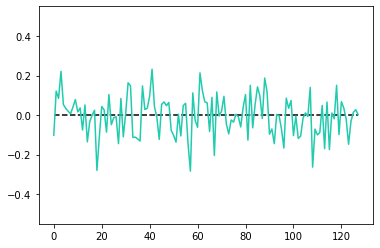

56


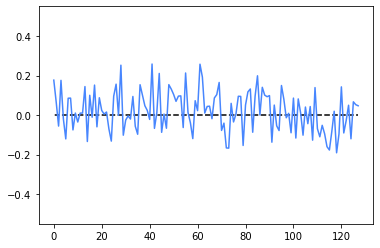

57


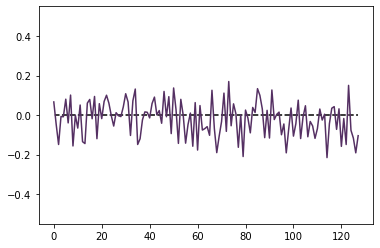

58


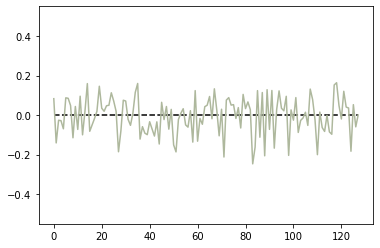

59


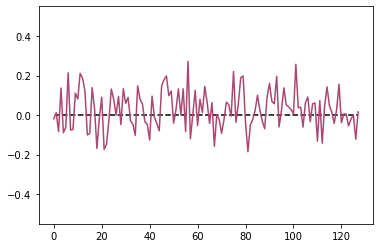

60


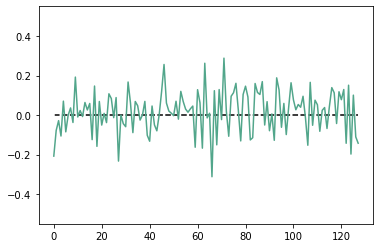

61


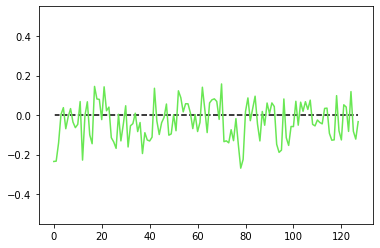

62


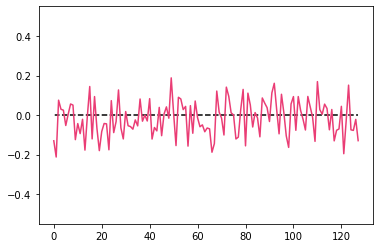

63


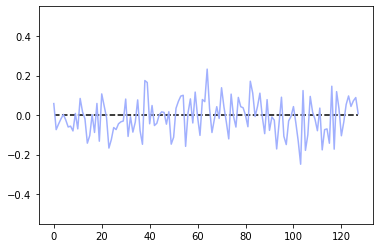

In [42]:
# visualize convolutional layer weights
my_model.layers
cn.plot_convlayer_weights(my_model, layer_num = 1)
cn.plot_denselayer_weights(my_model, layer_num = -3)
